<a href="https://colab.research.google.com/github/pranayDgr8/Earthquake-Prediction-using-SVM/blob/main/Earthquake_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle

In [2]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 97 kB/s 


In [3]:
import pandas as pandas
import numpy as np
from catboost import CatBoostRegressor,Pool
from sklearn.preprocessing import StandardScaler
from sklearn.svm import  NuSVR,SVR
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt


In [4]:
from google.colab import files
upld=files.upload()


Saving kaggle.json to kaggle.json


In [6]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [7]:
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/325k [00:00<?, ?B/s]
100% 325k/325k [00:00<00:00, 49.4MB/s]
  0% 0.00/316k [00:00<?, ?B/s]
100% 316k/316k [00:00<00:00, 100MB/s]
  0% 0.00/312k [00:00<?, ?B/s]
100% 312k/312k [00:00<00:00, 44.3MB/s]
  0% 0.00/329k [00:00<?, ?B/s]
100% 329k/329k [00:00<00:00, 109MB/s]
  0% 0.00/310k [00:00<?, ?B/s]
100% 310k/310k [00:00<00:00, 100MB/s]
  0% 0.00/329k [00:00<?, ?B/s]
100% 329k/329k [00:00<00:00, 101MB/s]
  0% 0.00/321k [00:00<?, ?B/s]
100% 321k/321k [00:00<00:00, 102MB/s]
  0% 0.00/320k [00:00<?, ?B/s]
100% 320k/320k [00:00<00:00, 104MB/s]
  0% 0.00/330k [00:00<?, ?B/s]
100% 330k/330k [00:00<00:00, 129MB/s]
  0% 0.00/332k [00:00<?, ?B/s]
100% 332k/332k [00:00<00:00, 106MB/s]
  0% 0.00/319k [00:00<?, ?B/s]
100% 319k/319k [00:00<00:00, 98.2MB/s]
  0% 0.00/315k [00:00<?, ?B/s]
100% 315k/315k [00:00<00:00, 96.9MB/s]
  0% 0.00/360k [00:00<?, ?B/s]
100% 360k/360k [00:00<00:00, 110MB/s]
  0% 0.00/320k [00:00<?, ?B/s]
100% 320k/320k [00:00<00:00, 163MB/s]
  0% 0.00/324k [00:00<?, ?B/s]

In [8]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


## EDA

In [37]:
train=pandas.read_csv('train.csv',nrows=6000000,dtype={'accoustic_data':np.int16,'time_to_failure':np.float64})

In [10]:
train

,acoustic_data,time_to_failure
0,12,1.469100
1,6,1.469100
2,8,1.469100
3,5,1.469100
4,8,1.469100
...,...,...
5999995,6,11.452496
5999996,5,11.452496
5999997,4,11.452496
5999998,3,11.452496


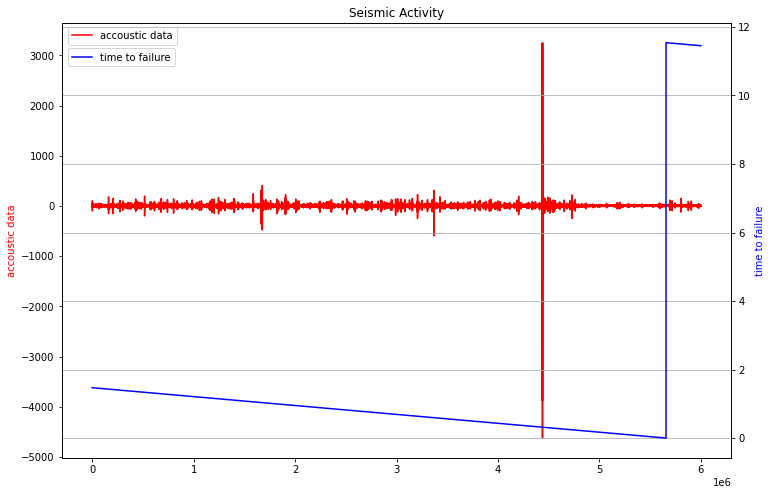

In [26]:
train_accdata=train['acoustic_data'].values[::]
train_fail_tim=train['time_to_failure'].values[::]


def plot_my_data(sample1,sample2):
  fig,ax1=plt.subplots(figsize=(12,8))
  plt.title('Seismic Activity')
  plt.plot(sample1,color='r')
  ax1.set_ylabel('accoustic data',color='r')
  plt.legend(['accoustic data'],loc=(0.01,0.95))
  ax2=ax1.twinx()
  plt.plot(sample2,color='b')
  ax2.set_ylabel('time to failure',color='b')
  plt.legend(['time to failure'],loc=(0.01,0.9))
  plt.grid(True)

plot_my_data(train_accdata,train_fail_tim)
del train_accdata
del train_fail_tim

## Feature Engineering

In [44]:
import pandas as pd
def gen_features(X):
  strain=[]
  strain.append(X.mean)
  
  strain.append(X.std())
  strain.append(X.min())
  strain.append(X.max())
  strain.append(X.kurtosis())
  strain.append(X.skew())
  strain.append(np.quantile(X,0.01))
  strain.append(np.quantile(X,0.05))
  strain.append(np.quantile(X,0.95))
  strain.append(np.quantile(X,0.99))
  strain.append(np.abs(X).max())
  strain.append(np.abs(X).mean())
  strain.append(np.abs(X).std())

  return pd.Series(strain)  
      
 
    

In [50]:

train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    print(ch[1:])
    X_train = X_train.append(ch[1:], ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


Streaming output truncated to the last 5000 lines.
6         -19.0
7          -4.0
8          13.0
9          29.0
10          233
11      6.45432
12     9.015077
dtype: object
1     5.850196
2          -88
3          110
4     27.77758
5     0.003748
6        -12.0
7         -3.0
8         12.0
9         21.0
10         110
11     5.64416
12    4.897243
dtype: object
1      19.227258
2           -895
3            652
4     432.376657
5      -1.712471
6          -27.0
7           -5.0
8           14.0
9           35.0
10           895
11      7.337987
12     18.326699
dtype: object
1      8.353157
2          -115
3           166
4     34.364478
5      0.185574
6         -21.0
7          -4.0
8          13.0
9          30.0
10          166
11     6.238047
12     7.111165
dtype: object
1       7.478368
2           -202
3            242
4     122.460332
5       1.208825
6          -14.0
7           -3.0
8           12.0
9           23.0
10           242
11      5.712347
12       6.56213
d

In [51]:
X_train

,1,2,3,4,5,6,7,8,9,10,11,12
0,5.101106,-98.0,104.0,33.662481,-0.024061,-8.0,-2.0,11.0,18.0,104.0,5.576567,4.333325
1,6.588824,-154.0,181.0,98.758517,0.390561,-11.0,-2.0,12.0,21.0,181.0,5.734167,5.732777
2,6.967397,-106.0,140.0,33.555211,0.217391,-15.0,-3.0,13.0,26.0,140.0,6.152647,5.895945
3,6.922305,-199.0,197.0,116.548172,0.757278,-12.0,-2.0,12.0,22.0,199.0,5.933960,6.061214
4,7.301110,-126.0,145.0,52.977905,0.064531,-15.0,-2.0,12.0,26.0,145.0,6.110587,6.329485
...,...,...,...,...,...,...,...,...,...,...,...,...
4190,3.911331,-60.0,82.0,28.942916,0.161954,-5.0,-1.0,9.0,14.0,82.0,4.815673,3.404313
4191,3.221462,-39.0,63.0,9.986985,0.142006,-3.0,0.0,9.0,12.0,63.0,4.825280,2.884574
4192,4.160361,-97.0,94.0,60.777372,0.029714,-4.0,-1.0,10.0,13.0,97.0,4.878973,3.666459
4193,3.375554,-66.0,64.0,15.873626,-0.123669,-3.0,0.0,9.0,12.0,66.0,4.786893,2.982606


In [52]:
#Model #1 - Catboost

train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 1.397469724354024}}

In [53]:
#Model #2 - Support Vector Machine w/ RBF + Grid Search

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -2.1701
{'C': 2, 'gamma': 0.02}
